In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
from sklearn.cluster import KMeans

import seaborn as sns
sns.set(style='darkgrid')
import plotly.graph_objects as go

import sys
sys.path.append('../src') 

from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
from kneed import KneeLocator

def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

def identify_weak_support_resistance(data):
    # Initialize an empty list to store the labels (support, resistance, neither)
    labels = []

    # Iterate through the dataframe to identify weak support and weak resistance
    for i in range(len(data)):
        if i == 0 or i == len(data) - 1:
            # Edge cases where there's no previous or following day
            labels.append("neither")
        elif data['close'][i] < data['close'][i - 1] and data['close'][i] < data['close'][i + 1]:
            # Weak support condition
            labels.append("weak support")
        elif data['close'][i] > data['close'][i - 1] and data['close'][i] > data['close'][i + 1]:
            # Weak resistance condition
            labels.append("weak resistance")
        else:
            # Neither weak support nor weak resistance
            labels.append("neither")

    # Add the labels to a new column in the dataframe
    data['Support/Resistance'] = labels

    return data

In [3]:
def plot_stock(stock_name,
               start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'),
               end=datetime.today(),
               figsize=(12, 6),
               interactive=False,
               return_result=False,
              ):
    '''
    Input:
    stock_name: str
    start: datetime
    end: datetime
    '''
    df = yf.download(stock_name.upper(),
                     start=start,
                     end=end)
    df = df.reset_index()
    df.columns = df.columns.str.lower()

    df['20 Day MA'] = df['close'].rolling(window=20).mean()
    df['20 Day STD'] = df['close'].rolling(window=20).std()
    
    # Calculate upper and lower bands
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    close = df.iloc[-1]['close']
    print('* previous stock price closing', round(close,2))
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
    print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])

    # df = identify_weak_support_resistance(df)
    
    # low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"close"]].set_index('date'))
    # low_centers = low_clusters.cluster_centers_
    # low_centers = np.sort(low_centers, axis=0)
    
    # high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"close"]].set_index('date'))
    # high_centers = high_clusters.cluster_centers_
    # high_centers = np.sort(high_centers, axis=0)
    
    # print('Supports')
    # print([low[0] for low in low_centers[:]])
    # print('Resistance')
    # print([high[0] for high in high_centers[:]])
    if interactive:
        fig = go.Figure(layout=dict(width=figsize[0]*80, height=figsize[1]*80))
        
        fig.add_trace(go.Scatter(x=df['date'], y=df['close'], name='Daily Price'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['20 Day MA'], mode='lines', line=dict(dash='dash'), name='20 Day MA'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['Lower Band'], mode='lines', line=dict(dash='dash'), name='Lower Band'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['Upper Band'], mode='lines', line=dict(dash='dash'), name='Upper Band', fill='tonexty', fillcolor='rgba(128,128,128,0.3)'))
        
        # for low in low_centers[:]:
        #     fig.add_trace(go.Scatter(x=df['date'], y=[low[0]]*len(df['date']), mode='lines', line=dict(color='green', dash='dash'), name='Support at ' + str(low[0])))
        # for high in high_centers[:]:
        #     fig.add_trace(go.Scatter(x=df['date'], y=[high[0]]*len(df['date']), mode='lines', line=dict(color='red', dash='dash'), name='Resistance at ' + str(high[0])))        
        fig.update_layout(title='Interactive Plot of Daily Stock Price for ' + stock_name,
                          xaxis_title='date',
                          yaxis_title='Daily Price',
                          hovermode='closest')
        
        # Add ability to select a single data point
        fig.update_traces(marker=dict(size=10, opacity=0.8),
                          selector=dict(mode='markers'))
        
        fig.show()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        ax.grid(True, alpha=0.5)
    
        ax.plot(df['date'], df['close'], label='Daily Close Price')
        ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
        ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
        ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
        ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands
    
        ax.set_title('Daily stock price for ' + stock_name)
        ax.legend()
        
        # for low in low_centers[:]:
    	   #  ax.axhline(low[0], color='green', ls='--')
        # for high in high_centers[:]:
    	   #  ax.axhline(high[0], color='red', ls='--')

    if return_result:
        return df

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 471.48
Latest 20 Day MA: 475.8470031738281
Latest Lower Bollinger Band: 468.2730555012813
Latest Higher Bollinger Band: 483.4209508463749


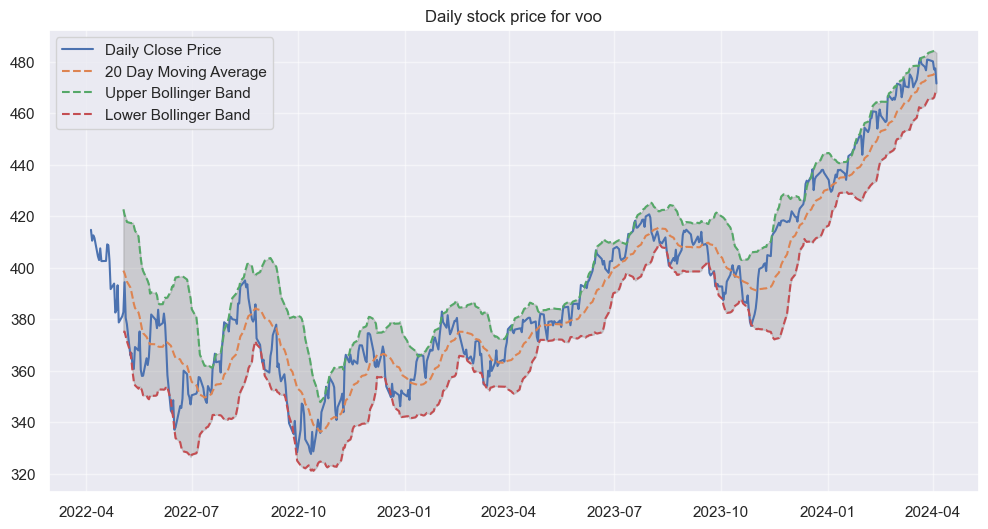

In [4]:
plot_stock('voo')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 471.48
Latest 20 Day MA: 475.8470031738281
Latest Lower Bollinger Band: 468.2730555012813
Latest Higher Bollinger Band: 483.4209508463749


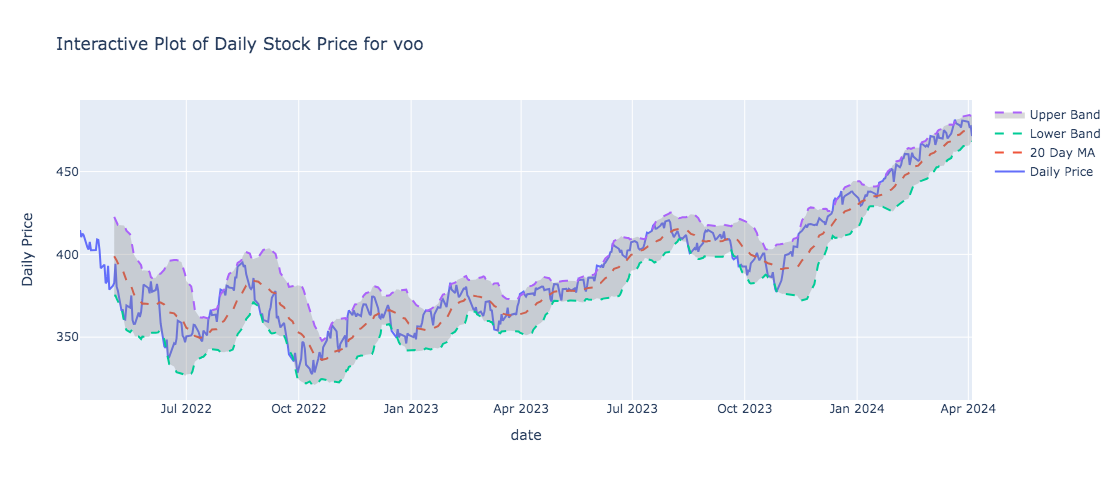

In [5]:
plot_stock('voo', interactive=True)

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 179.12
Latest 20 Day MA: 181.71750030517578
Latest Lower Bollinger Band: 178.6998893183411
Latest Higher Bollinger Band: 184.73511129201046


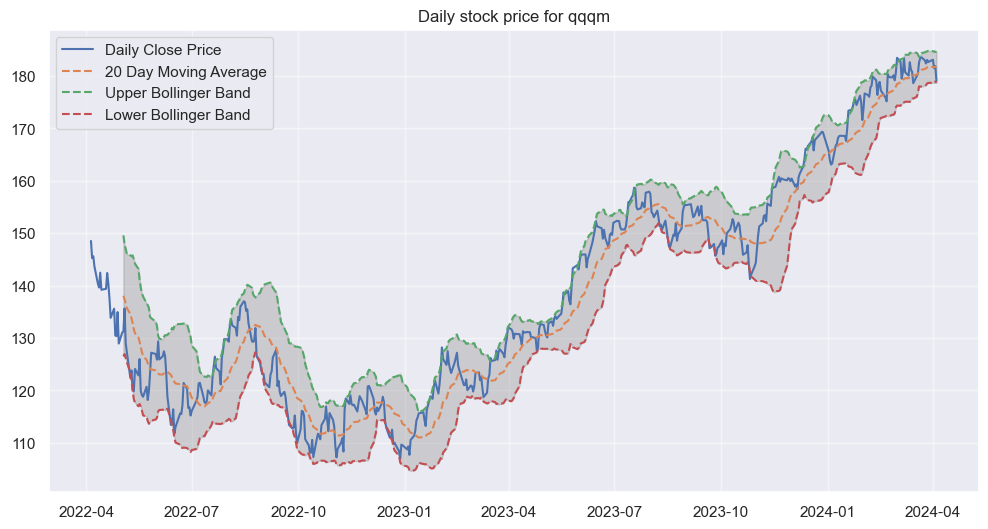

In [6]:
plot_stock('qqqm')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 415.32
Latest 20 Day MA: 411.67750396728513
Latest Lower Bollinger Band: 399.9199750722424
Latest Higher Bollinger Band: 423.4350328623279


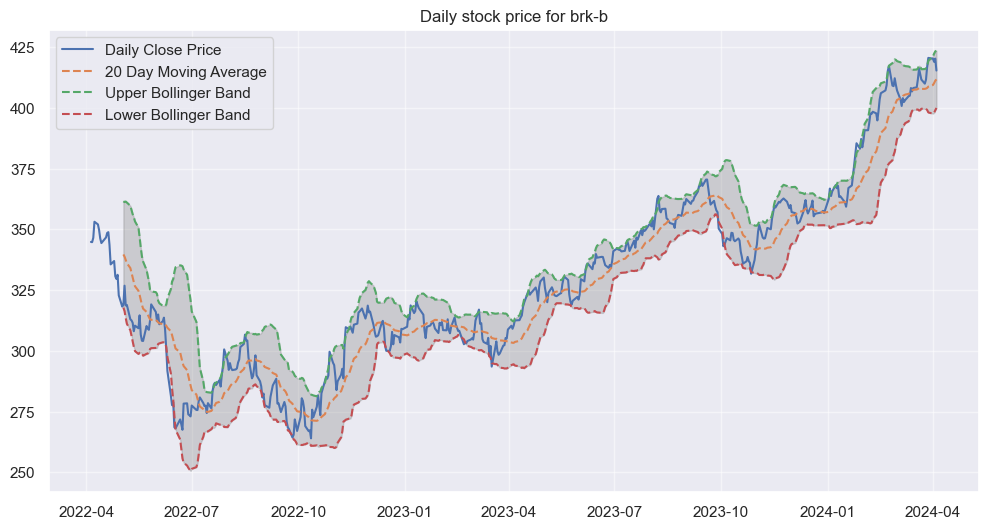

In [7]:
plot_stock('brk-b')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 414.03
Latest 20 Day MA: 427.14150085449216
Latest Lower Bollinger Band: 410.60787214033576
Latest Higher Bollinger Band: 443.6751295686486


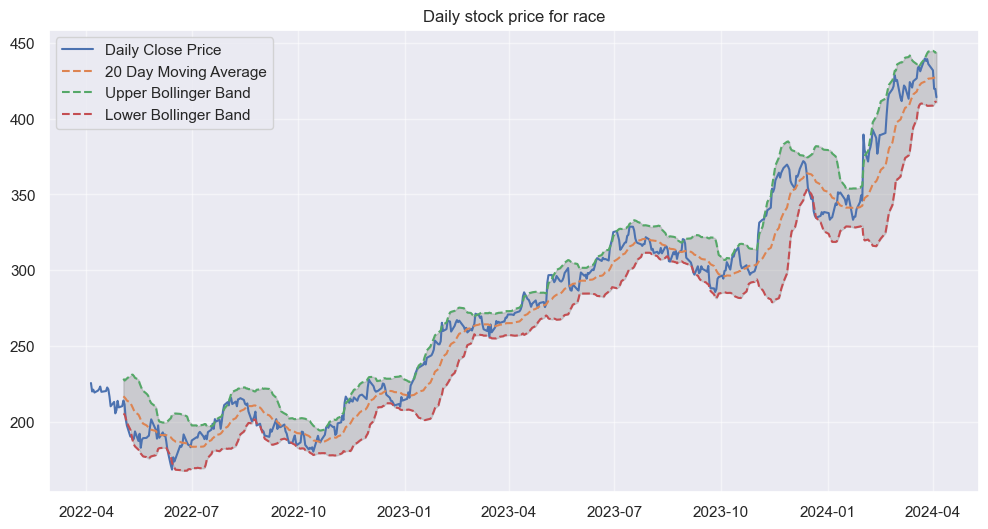

In [8]:
plot_stock('race')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 168.82
Latest 20 Day MA: 171.8634994506836
Latest Lower Bollinger Band: 166.89877332174552
Latest Higher Bollinger Band: 176.8282255796217


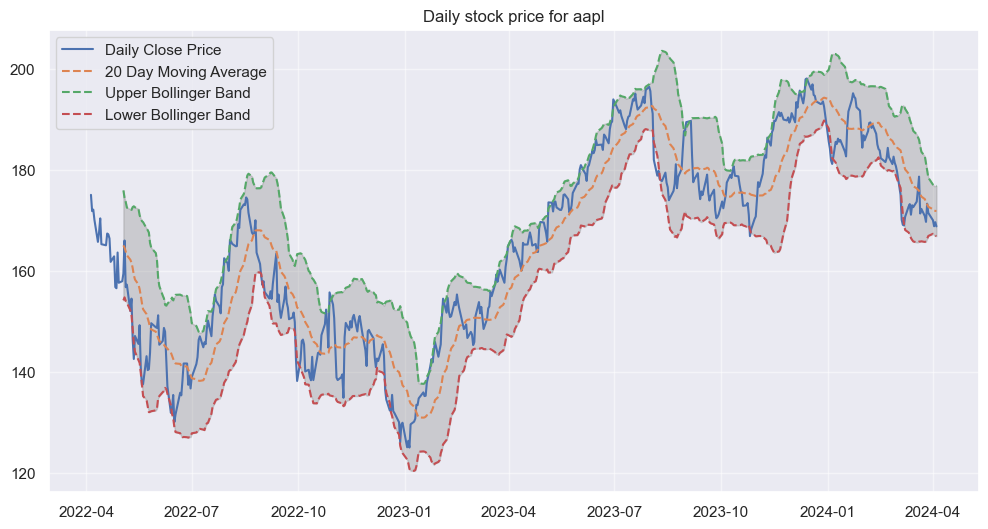

In [9]:
plot_stock('aapl')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 455.38
Latest 20 Day MA: 484.34900360107423
Latest Lower Bollinger Band: 459.6476468292072
Latest Higher Bollinger Band: 509.05036037294127


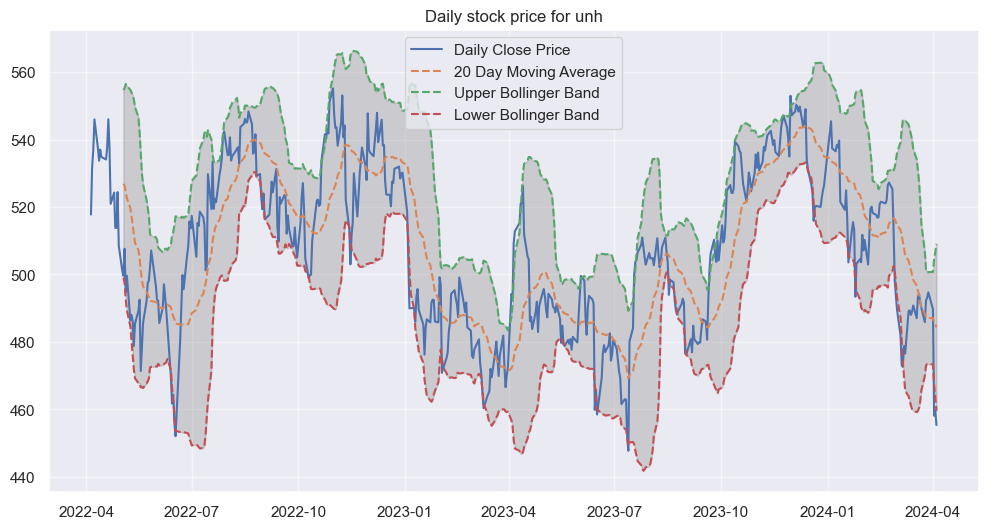

In [10]:
plot_stock('unh')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 704.88
Latest 20 Day MA: 730.2720001220703
Latest Lower Bollinger Band: 696.5107948165031
Latest Higher Bollinger Band: 764.0332054276374


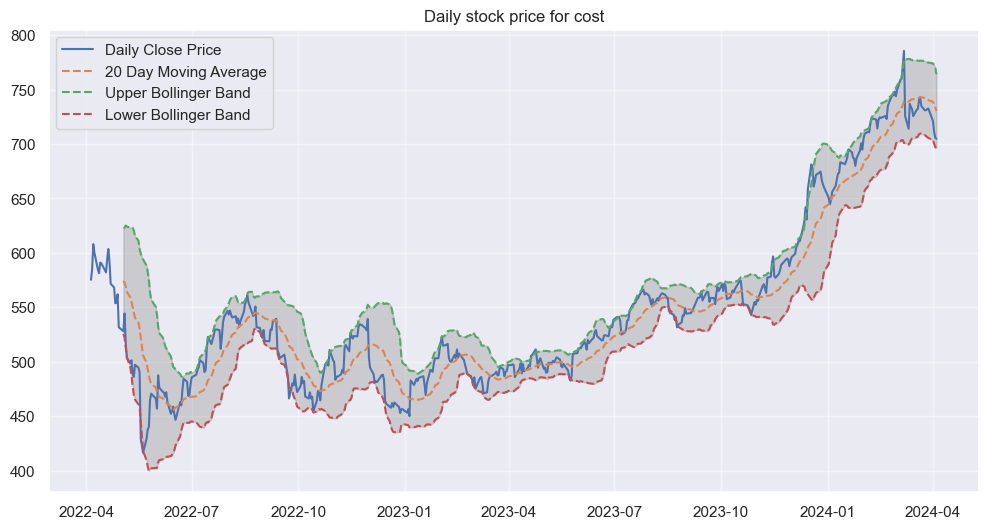

In [11]:
plot_stock('cost')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 357.56
Latest 20 Day MA: 428.455500793457
Latest Lower Bollinger Band: 343.22483607444417
Latest Higher Bollinger Band: 513.6861655124699


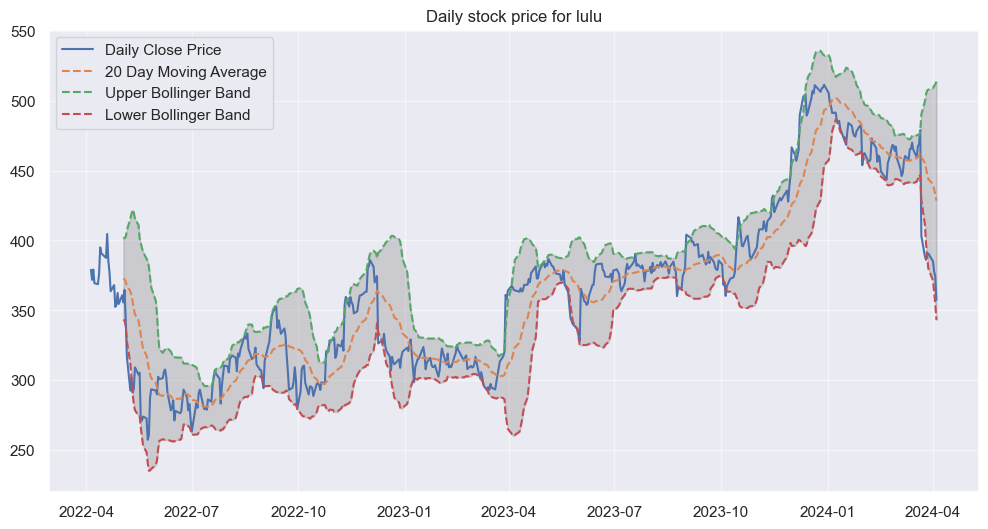

In [12]:
plot_stock('lulu')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 142.13
Latest 20 Day MA: 140.9160011291504
Latest Lower Bollinger Band: 134.09627709325528
Latest Higher Bollinger Band: 147.73572516504552
0.06007067137809187


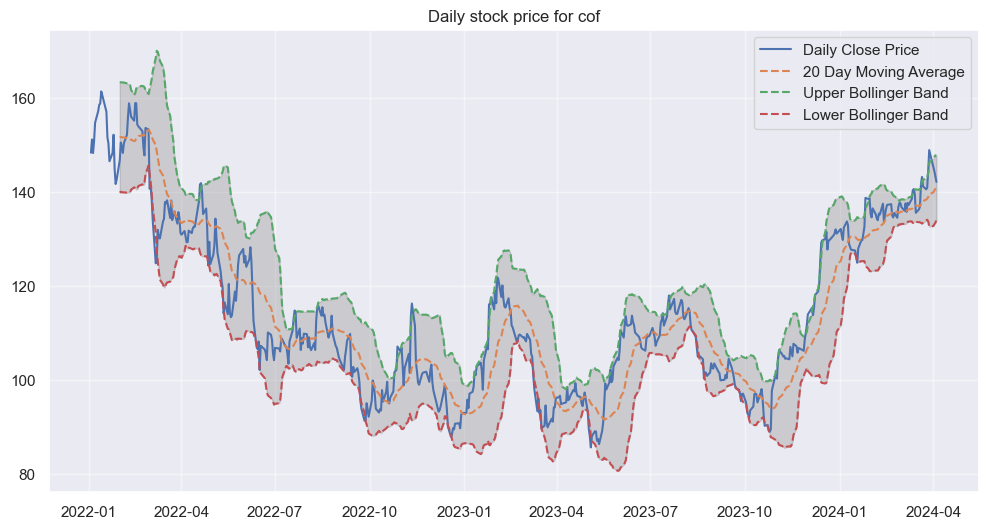

In [13]:
df_cof = plot_stock('cof', start="2022-01-01", return_result=True)
print(df_cof[df_cof['close']>=df_cof['Upper Band']].shape[0] / df_cof.shape[0])

In [14]:
supports = [ 88.94250043,
  94.01933339,
 100.19388877,
 106.30250032,
 114.39529419,
 124.61666743,
 130.01571328,
 134.50785828,
 139.36166382,
 149.19599915,]
resistance = [90.8, 97.56, 103.23, 108.54, 114.94, 118.73, 131.04, 138.07, 151.26, 159.7]

In [15]:
def find_closest_number(x, num_list):
    closest = min(num_list, key=lambda num: abs(num - x))
    return closest
df_cof['closed_support'] = df_cof['Lower Band'].apply(find_closest_number, args=(supports,))
df_cof['closed_resistance'] = df_cof['Upper Band'].apply(find_closest_number, args=(resistance,))
df_cof[~df_cof['20 Day MA'].isna()].head()

date        open        high         low       close   adj close  \
19 2022-01-31  141.339996  147.009995  140.410004  146.729996  139.853424   
20 2022-02-01  147.000000  150.860001  145.979996  150.490005  143.437241   
21 2022-02-02  149.479996  150.539993  146.929993  149.619995  142.607986   
22 2022-02-03  148.910004  151.110001  147.899994  148.289993  141.340317   
23 2022-02-04  149.000000  151.880005  148.570007  150.350006  143.303787   

     volume   20 Day MA  20 Day STD  Upper Band  Lower Band  closed_support  \
19  3789000  151.570998    5.870166  163.311330  139.830665      139.361664   
20  3063900  151.678498    5.827414  163.333325  140.023671      139.361664   
21  2446600  151.601998    5.844734  163.291465  139.912531      139.361664   
22  1978000  151.603498    5.843835  163.291167  139.915829      139.361664   
23  2201200  151.584499    5.847441  163.279380  139.889617      139.361664   

    closed_resistance  
19              159.7  
20              159.7  
21              159.7  
22              159.7  
23              159.7

In [16]:
df_cof[df_cof['close']>=df_cof['Upper Band']][['date','close', 'Upper Band', 'closed_resistance']]

date       close  Upper Band  closed_resistance
73  2022-04-19  141.589996  139.839475             138.07
74  2022-04-20  141.850006  140.764648             138.07
135 2022-07-19  113.019997  112.077124             114.94
136 2022-07-20  114.760002  113.516201             114.94
204 2022-10-25  101.580002  101.204312             103.23
207 2022-10-28  107.099998  104.819727             103.23
216 2022-11-10  113.419998  111.241093             108.54
217 2022-11-11  116.250000  113.845817             114.94
257 2023-01-11  101.790001  101.366797             103.23
266 2023-01-25  116.089996  112.277372             114.94
267 2023-01-26  116.070000  114.916463             114.94
268 2023-01-27  117.580002  117.270254             118.73
382 2023-07-13  114.180000  113.954527             114.94
385 2023-07-18  116.070000  115.303168             114.94
386 2023-07-19  117.959999  116.811601             114.94
461 2023-11-02  104.650002  104.382388             103.23
462 2023-11-03  106.320000  106.184485             108.54
479 2023-11-29  110.129997  109.808235             108.54
480 2023-11-30  111.660004  110.270929             108.54
481 2023-12-01  113.930000  111.897158             114.94
482 2023-12-04  114.940002  113.474622             114.94
483 2023-12-05  115.320000  114.855871             114.94
486 2023-12-08  118.089996  118.082758             118.73
489 2023-12-13  125.089996  123.398871             118.73
490 2023-12-14  129.199997  126.568826             131.04
491 2023-12-15  129.679993  129.157072             131.04
518 2024-01-26  138.720001  136.555784             138.07
519 2024-01-29  138.479996  137.839402             138.07
549 2024-03-12  140.270004  139.710690             138.07
550 2024-03-13  140.610001  140.224107             138.07
555 2024-03-20  141.770004  141.273853             138.07
556 2024-03-21  143.179993  142.270985             138.07
560 2024-03-27  144.509995  144.090613             138.07
561 2024-03-28  148.889999  146.265771             151.26

In [17]:
df_cof[df_cof['close']<=df_cof['Lower Band']][['date','close', 'Lower Band', 'closed_support']]

date       close  Lower Band  closed_support
39  2022-03-01  140.679993  143.868433      139.361664
40  2022-03-02  141.199997  142.030364      139.361664
41  2022-03-03  138.520004  139.794197      139.361664
42  2022-03-04  134.119995  136.761248      134.507858
43  2022-03-07  124.800003  131.264069      130.015713
44  2022-03-08  126.080002  127.182531      124.616667
79  2022-04-27  124.349998  124.591093      124.616667
90  2022-05-12  114.150002  114.797029      114.395294
111 2022-06-13  107.010002  107.889565      106.302500
114 2022-06-16  102.110001  102.359720      100.193889
181 2022-09-22   95.470001   96.023420       94.019333
182 2022-09-23   93.779999   94.916386       94.019333
183 2022-09-26   91.300003   92.944885       94.019333
241 2022-12-16   90.099998   90.305901       88.942500
242 2022-12-19   87.870003   88.576996       88.942500
296 2023-03-09  100.940002  101.977529      100.193889
297 2023-03-10   98.190002   99.947638      100.193889
298 2023-03-13   93.320000   96.892659       94.019333
300 2023-03-15   92.930000   93.453710       94.019333
332 2023-05-01   93.169998   93.337972       94.019333
333 2023-05-02   89.550003   91.734106       94.019333
334 2023-05-03   88.029999   90.036009       88.942500
335 2023-05-04   85.629997   88.012824       88.942500
402 2023-08-10  110.540001  110.560750      114.395294
404 2023-08-14  109.160004  109.464295      106.302500
405 2023-08-15  106.910004  108.085258      106.302500
406 2023-08-16  104.919998  106.543735      106.302500
407 2023-08-17  105.070000  105.204643      106.302500
410 2023-08-22  100.300003  101.195960      100.193889
435 2023-09-27   95.489998   96.116568       94.019333
439 2023-10-03   93.050003   93.536760       94.019333
452 2023-10-20   90.230003   90.805756       88.942500
511 2024-01-17  126.080002  126.140767      124.616667
512 2024-01-18  124.919998  125.250059      124.616667